In [1]:
from operator import itemgetter
import random
import matplotlib.pyplot as plt
import numpy as np
import queue
import pandas as pd
import random,time
import threading
from datetime import datetime, date
from io import StringIO
from multiprocessing import Pool
from multiprocessing import Process ,  Queue
from itertools import repeat

from random_forest import random_forest_Fitness_Process , random_forest_decode

In [2]:

#初始種群
def init_population(pop_size,dna_length):
    population = []
    np.random.seed(1108)   #隨機種子
    for num in range(pop_size):
      chromosome = ''
      for len in range(dna_length):
        chromosome = chromosome+str(np.random.randint(0,2))
      
      population.append(chromosome)

    return population







#計算適應度
def evaluate_fitness(pop , training_data , training_data_label , train_year):
    fitness = []
    

    
    # processes數量
    CPU_Core_num = 6
    pool = Pool(processes = CPU_Core_num)
    # 把全部資料丟進process跑 checksize = population / proccess數量
    cal_result = pool.starmap(random_forest_Fitness_Process , zip(pop, repeat(training_data) , repeat(training_data_label) , repeat(train_year)) , chunksize = int(len(pop) / CPU_Core_num) )
    # cal_result = pool.starmap(BollingerBand_Fitness_Process , zip(pop, repeat(training_data) , repeat(period) , repeat (init_money)) , chunksize = int(len(pop) / CPU_Core_num) )
    


    for r in range(len(pop)):
        fitness.append([pop[r] , cal_result[r]])
    

    return max(cal_result) , sum(cal_result)/len(pop) , fitness
    


#選擇 & 交配
def cross(pop,POP_SIZE,DNA_LEN,cross_rate):
    new_pop = []
    while len(new_pop) != POP_SIZE:
        ran_F = random.choices(pop, k=2)
        ran_M = random.choices(pop, k=2)
        father = max(ran_F, key = itemgetter(1))[0]
        mother = max(ran_M, key = itemgetter(1))[0]

        if np.random.rand() < cross_rate:
            cross_point = np.random.randint(low=0, high = DNA_LEN)
            cut_F = father[cross_point:]
            cut_M = mother[cross_point:]
            father = father[:cross_point]+cut_M
            mother = mother[:cross_point]+cut_F

        new_pop.extend([father,mother])

    return new_pop


#變異
def mutation(pop,DNA_LEN,mutation_rate):
    
    for m in range(len(pop)):
        if np.random.rand() < mutation_rate:
          mutation_gene  = np.random.randint(DNA_LEN)
          mu_chromosome = list(pop[m])
          if mu_chromosome[mutation_gene] == '1':
            mu_chromosome[mutation_gene] = '0'
          else:
            mu_chromosome[mutation_gene] = '1'
          
          pop[m] = ''.join(mu_chromosome)

    return pop


#繪製種群狀態
def draw_fitness(run,best_pop,avg_pop):
    plt.title("Best & Avg fitness")  #圖表標題
    plt.xlabel("Generation")  #圖表x軸標題
    plt.ylabel("fitness")  #圖表y軸標題
    plt.plot(run, best_pop, color='r', label='Best fitness', linestyle='-', marker='*')   #定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.plot(run, avg_pop, color='b', label='Avg fitness', linestyle='--', marker='o')
    plt.grid(axis='y')    #定義網格
    plt.legend(loc='lower right')   #當有兩種以上資料,可以使用.legend()來顯示資料的圖例

In [3]:
def train( training_data , train_data_label , train_years):
    run = []
    best_fitness = []
    avg_fitness = []

    POP_SIZE = 400    #種群大小
    
    '''
    Random Forest 34 bit
    n_estimators        : 31 ~ 158 = range 0~127 = 6bit         樹的數量
    max_depth           : 10 ~ 41 = range 0~31 = 4bit           最大深度
    min_samples_split   : 0.0 ~ 100.0 = range 0 ~ 127 = 6 bit   內部節點需要的最小sample數量
    min_samples_leaf    : 0.0 ~ 100.0 = range 0 ~ 127 = 6 bit   葉子至少需要的sample數量
    max_features        : 0.0 ~ 100.0 = range 0 ~ 127 = 6 bit   每個決策最多用到的features數量
    oob_score           : 0 or 1                                是否使用out of bag
    max_samples         : 0.0 ~ 100.0 = range 0 ~ 127 = 6 bit   每棵樹使用的sample數量

    '''

    DNA_LEN = 35    # 
    cross_rate = 0.7    #交配概率
    mutation_rate = 0.005   #變異概率

    #初始種群
    pop = init_population(POP_SIZE,DNA_LEN)


    #迭代次數
    generation_num = 20
    best_chromosome = ""
    best_fit = -1e9


    for i in range(generation_num):
        print(f"[Generation : {i+1}]")
        max_fit , avg_fit, pop = evaluate_fitness(pop , training_data , train_data_label , train_years) #計算適應度
        print(f" Best chromosome : {random_forest_decode(sorted(pop, reverse=True, key = itemgetter(1))[0][0])}\n {sorted(pop, reverse=True, key = itemgetter(1))[0][0]}\n Best fitness:{max_fit}\n Avg fitness:{avg_fit}\n")
        # print(f" Best chromosome:{BollingerBand_decode(sorted(pop, reverse=True, key = itemgetter(1))[0][0])}\n Best fitness:{max_fit}\n Avg fitness:{avg_fit}\n")

        if best_fit < max_fit :
            best_fit = max_fit
            best_chromosome = sorted(pop, reverse=True, key = itemgetter(1))[0][0]

        pop = cross(pop,POP_SIZE,DNA_LEN,cross_rate)  #交配 
        pop = mutation(pop,DNA_LEN,mutation_rate) #變異

        best_fitness.append(max_fit)
        avg_fitness.append(avg_fit)
        run.append(i+1)

    draw_fitness(run,best_fitness,avg_fitness)

    return best_chromosome


[Generation : 1]
 Best chromosome:(71, 25, 0.001, 0.001, 0.11023622047244094, 0.360375, 1)
 Best fitness:0.5853480298560749
 Avg fitness:0.014679221127215402

[Generation : 2]
 Best chromosome:(31, 25, 0.001, 0.001, 0.11023622047244094, 0.360375, 1)
 Best fitness:0.5761579891700193
 Avg fitness:0.02536055880118436

[Generation : 3]
 Best chromosome:(31, 25, 0.001, 0.001, 0.03937007874015748, 0.4150625, 0)
 Best fitness:0.6289187989955392
 Avg fitness:0.041082441180427386

[Generation : 4]
 Best chromosome:(31, 25, 0.001, 0.001, 0.03937007874015748, 0.4385, 0)
 Best fitness:0.6375277667117676
 Avg fitness:0.06273601549945486

[Generation : 5]
 Best chromosome:(31, 25, 0.001, 0.001, 0.031496062992125984, 0.4931875, 1)
 Best fitness:0.6760819021770825
 Avg fitness:0.10731314274681042

[Generation : 6]
 Best chromosome:(31, 25, 0.001, 0.001, 0.031496062992125984, 0.4931875, 1)
 Best fitness:0.6760819021770825
 Avg fitness:0.1517350905923981

[Generation : 7]
 Best chromosome:(31, 25, 0.001

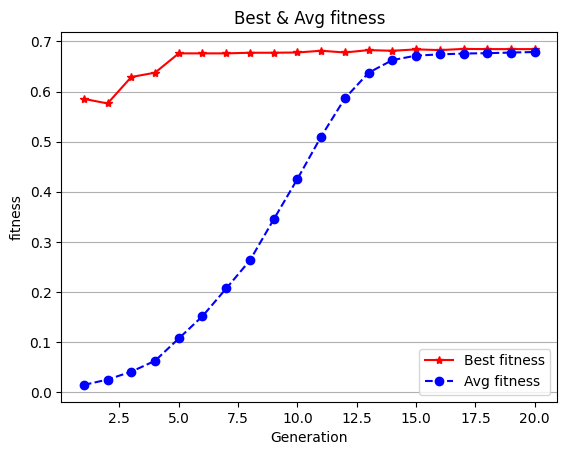

In [4]:
if __name__ == '__main__':  
    data = pd.read_csv('./top200_training.csv')  #讀取csv資料檔

    stocks_data = pd.read_csv('./top200_training.csv' )
    stocks_data = stocks_data.drop(columns=['證券代碼'])
    data_years = stocks_data['年月'].unique()

       # for split_year in split_year_li:
    for train_years in range(3,4):

        train_data = stocks_data[stocks_data['年月'].isin(data_years[:train_years])]
        train_data_label = train_data['Return']
        train_data = train_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

        test_data = stocks_data[stocks_data['年月'].isin(data_years[train_years:-1])]
        test_data_label = test_data['Return']
        test_data = test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])
        

        
        # train出最好的染色體
        best_chromosome = train(train_data , train_data_label , train_years)

